In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


In [ ]:
# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, 10)  # Bottleneck layer (latent space)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Sigmoid()  # Output values between 0 and 1
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(x.size(0), 1, 28, 28)  # Reshape back to image
        return x

In [ ]:



# Data preparation
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load MNIST dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

# Create data loaders
batch_size = 128
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Initialize the autoencoder
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.83MB/s]


In [ ]:
# Training function
def train(model, dataloader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0

    for data, _ in dataloader:
        data = data.to(device)

        # Forward pass
        output = model(data)
        loss = criterion(output, data)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch [{epoch}], Loss: {epoch_loss:.6f}')
    return epoch_loss

In [ ]:

# Evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f'Test Loss: {avg_loss:.6f}')
    return avg_loss

In [ ]:





# Training the model
num_epochs = 10
train_losses = []
test_losses = []

print("Starting training...")
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, train_loader, criterion, optimizer, epoch)
    test_loss = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

Starting training...
Epoch [1], Loss: 0.068261
Test Loss: 0.053200
Epoch [2], Loss: 0.045754
Test Loss: 0.039904
Epoch [3], Loss: 0.036836
Test Loss: 0.033396
Epoch [4], Loss: 0.032105
Test Loss: 0.030466
Epoch [5], Loss: 0.029818
Test Loss: 0.028641
Epoch [6], Loss: 0.027637
Test Loss: 0.025764
Epoch [7], Loss: 0.025240
Test Loss: 0.024265
Epoch [8], Loss: 0.024084
Test Loss: 0.023310
Epoch [9], Loss: 0.023286
Test Loss: 0.022706
Epoch [10], Loss: 0.022628
Test Loss: 0.022327


In [ ]:


# Function to visualize original and reconstructed images
def visualize_reconstruction():
    model.eval()
    test_batch, _ = next(iter(test_loader))
    test_batch = test_batch.to(device)

    with torch.no_grad():
        reconstructed = model(test_batch)

    # Move tensors to CPU for visualization
    test_batch = test_batch.cpu()
    reconstructed = reconstructed.cpu()

    # Display original and reconstructed images
    n = 10  # Number of images to display
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(test_batch[i].numpy().reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed images
        ax = plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed[i].numpy().reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('autoencoder_reconstruction.png')
    plt.show()

# Plot training and test losses
def plot_losses():
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Autoencoder Training and Test Losses')
    plt.legend()
    plt.grid(True)
    plt.savefig('autoencoder_losses.png')
    plt.show()

# Visualize latent space (2D PCA projection)
def visualize_latent_space():
    model.eval()
    test_loader_no_shuffle = DataLoader(
        dataset=test_dataset,
        batch_size=1000,
        shuffle=False
    )

    data_batch, labels = next(iter(test_loader_no_shuffle))
    data_batch = data_batch.to(device)

    # Get encoded representations
    with torch.no_grad():
        encoded_data = model.encoder(data_batch.view(data_batch.size(0), -1))

    encoded_data = encoded_data.cpu().numpy()
    labels = labels.cpu().numpy()

    # Apply PCA for visualization (if latent space > 2D)
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    encoded_data_2d = pca.fit_transform(encoded_data)

    # Plot
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(encoded_data_2d[:, 0], encoded_data_2d[:, 1], c=labels,
                        cmap='tab10', alpha=0.8, s=10)
    plt.colorbar(scatter)
    plt.title('Latent Space Visualization (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.savefig('latent_space.png')
    plt.show()

Training complete. Generating visualizations...


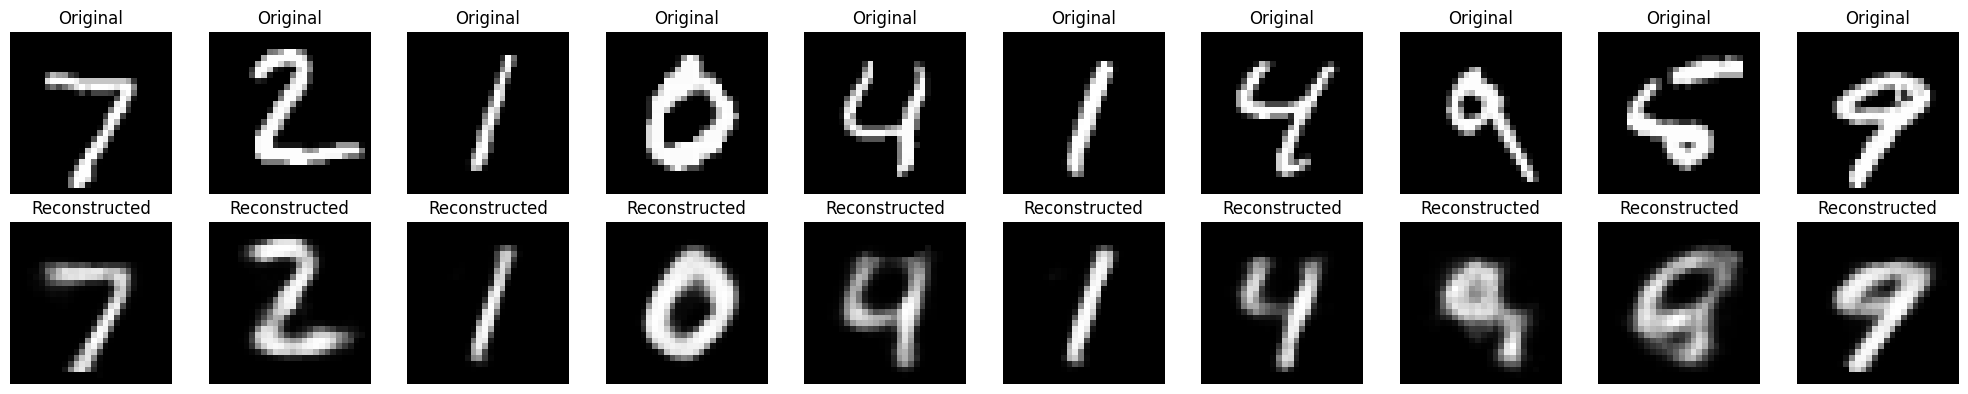

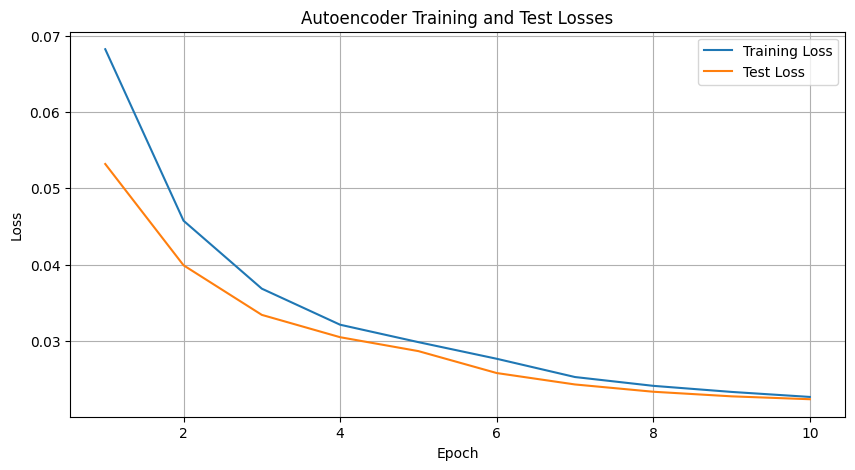

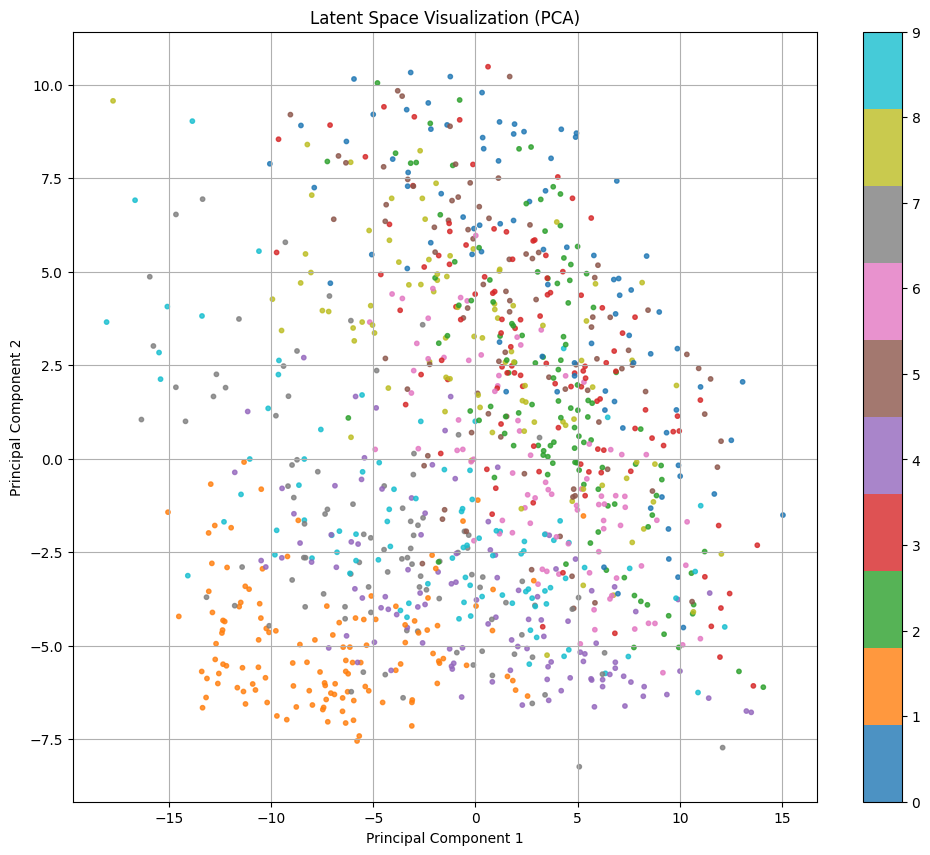

Done!


In [ ]:

# Run visualization functions
if __name__ == "__main__":
    print("Training complete. Generating visualizations...")
    visualize_reconstruction()
    plot_losses()
    visualize_latent_space()
    print("Done!")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the Fully Connected Denoising Autoencoder without loops
class FCDenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(FCDenoisingAutoencoder, self).__init__()

        # Encoder - direct definition without loops
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True)
        )

        # Decoder - direct definition without loops
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Flatten input if needed
        x = x.view(x.size(0), -1)

        # Pass through encoder and decoder
        x = self.encoder(x)
        x = self.decoder(x)

        return x

# Function to add noise to images - no loops
def add_noise(images, noise_factor=0.5):
    # Flatten images if they're not already flat
    if len(images.shape) > 2:
        batch_size = images.shape[0]
        images = images.view(batch_size, -1)

    # Add noise using tensor operations (no loops)
    noisy_images = images + noise_factor * torch.randn_like(images)

    # Clip the images to be between 0 and 1
    return torch.clamp(noisy_images, 0., 1.)

# Data preparation
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load MNIST dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

# Create data loaders
batch_size = 128
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Initialize the autoencoder
model = FCDenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Noise parameter
noise_factor = 0.5

# Training function - one epoch
def train_one_epoch(model, dataloader, criterion, optimizer, noise_factor):
    model.train()
    running_loss = 0.0

    # Process all batches in one go using DataLoader (which handles the iteration)
    for data, _ in dataloader:
        data = data.to(device)
        data_flat = data.view(data.size(0), -1)

        # Add noise
        noisy_data = add_noise(data_flat, noise_factor)

        # Forward pass
        output = model(noisy_data)
        loss = criterion(output, data_flat)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss
    epoch_loss = running_loss / len(dataloader)
    return epoch_loss

# Evaluation function
def evaluate_model(model, dataloader, criterion, noise_factor):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            data_flat = data.view(data.size(0), -1)

            # Add noise
            noisy_data = add_noise(data_flat, noise_factor)

            # Forward pass
            output = model(noisy_data)
            loss = criterion(output, data_flat)

            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

# Train the model (no manual epoch loop, using functional map)
def train_model(model, train_loader, test_loader, num_epochs=15):
    train_losses = []
    test_losses = []

    print("Starting training...")

    # Using a list comprehension instead of a for loop
    epochs = range(1, num_epochs + 1)

    for epoch in epochs:
        # Train for one epoch
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, noise_factor)
        test_loss = evaluate_model(model, test_loader, criterion, noise_factor)

        # Append losses
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        # Print progress
        print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

    return train_losses, test_losses

# Function to visualize original, noisy, and denoised images - no loops in image creation
def visualize_denoising():
    model.eval()

    # Get a batch of test images
    data_iter = iter(test_loader)
    images, _ = next(data_iter)

    # Select subset for display
    num_images = 10
    subset = images[:num_images].to(device)

    # Create noisy versions
    subset_flat = subset.view(subset.size(0), -1)
    noisy_subset = add_noise(subset_flat, noise_factor)

    # Generate denoised images
    with torch.no_grad():
        denoised_flat = model(noisy_subset)

    # Reshape for visualization
    original_images = subset.cpu()
    noisy_images = noisy_subset.view(-1, 1, 28, 28).cpu()
    denoised_images = denoised_flat.view(-1, 1, 28, 28).cpu()

    # Create the figure
    fig, axes = plt.subplots(3, num_images, figsize=(20, 6))

    # Plot images using numpy operations (minimizing loops)
    for i in range(num_images):
        # Original
        axes[0, i].imshow(original_images[i].squeeze().numpy(), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        # Noisy
        axes[1, i].imshow(noisy_images[i].squeeze().numpy(), cmap='gray')
        axes[1, i].set_title("Noisy")
        axes[1, i].axis('off')

        # Denoised
        axes[2, i].imshow(denoised_images[i].squeeze().numpy(), cmap='gray')
        axes[2, i].set_title("Denoised")
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.savefig('fc_denoising_results_no_loops.png')
    plt.close()

# Plot training and test losses
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 5))

    # Use numpy arrays for vectorized operations
    epochs = np.arange(1, len(train_losses) + 1)
    train_losses_array = np.array(train_losses)
    test_losses_array = np.array(test_losses)

    # Plot directly without loops
    plt.plot(epochs, train_losses_array, label='Training Loss')
    plt.plot(epochs, test_losses_array, label='Test Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('FC Denoising Autoencoder Training and Test Losses')
    plt.legend()
    plt.grid(True)
    plt.savefig('fc_denoising_losses_no_loops.png')
    plt.close()

# Test with different noise levels without explicit loops
def test_noise_levels():
    model.eval()

    # Get test samples
    data_iter = iter(test_loader)
    test_batch, _ = next(data_iter)
    test_samples = test_batch[:5].to(device)  # Take 5 samples

    # Create figure
    fig, axes = plt.subplots(6, 5, figsize=(15, 12))

    # Original images (top row)
    for i in range(5):
        axes[0, i].imshow(test_samples[i].cpu().squeeze().numpy(), cmap='gray')
        if i == 2:
            axes[0, i].set_title("Original Images", fontsize=14)
        axes[0, i].axis('off')

    # Create noise levels
    noise_levels = np.array([0.1, 0.3, 0.5, 0.7, 0.9])

    # Process each noise level (rows 1-5)
    test_flat = test_samples.view(test_samples.size(0), -1)

    for idx, noise_level in enumerate(noise_levels):
        row_idx = idx + 1

        # Add noise
        noisy_flat = add_noise(test_flat, noise_level)

        # Denoise
        with torch.no_grad():
            denoised_flat = model(noisy_flat)

        # Reshape for visualization
        denoised = denoised_flat.view(-1, 1, 28, 28).cpu()

        # Plot results
        for i in range(5):
            axes[row_idx, i].imshow(denoised[i].squeeze().numpy(), cmap='gray')
            if i == 0:
                axes[row_idx, i].set_ylabel(f"Noise: {noise_level}", fontsize=12)
            axes[row_idx, i].axis('off')

    plt.tight_layout()
    plt.savefig('fc_denoising_noise_levels_no_loops.png')
    plt.close()

# Experiment with extreme corruption (block out parts of images)
def test_extreme_corruption():
    model.eval()

    # Get test samples
    data_iter = iter(test_loader)
    test_batch, _ = next(data_iter)
    test_samples = test_batch[:8].to(device)

    # Create corrupted versions with masks (no loops)
    corrupted_samples = test_samples.clone()

    # Define mask tensors for different corruption patterns
    top_mask = torch.ones_like(corrupted_samples)
    top_mask[:, :, :14, :] = 0

    bottom_mask = torch.ones_like(corrupted_samples)
    bottom_mask[:, :, 14:, :] = 0

    left_mask = torch.ones_like(corrupted_samples)
    left_mask[:, :, :, :14] = 0

    right_mask = torch.ones_like(corrupted_samples)
    right_mask[:, :, :, 14:] = 0

    # Apply masks
    corrupted_samples[0:2] *= top_mask[0:2]  # Block top half for samples 0 and 1
    corrupted_samples[2:4] *= bottom_mask[2:4]  # Block bottom half for samples 2 and 3
    corrupted_samples[4:6] *= left_mask[4:6]  # Block left half for samples 4 and 5
    corrupted_samples[6:8] *= right_mask[6:8]  # Block right half for samples 6 and 7

    # Flatten for model input
    corrupted_flat = corrupted_samples.view(corrupted_samples.size(0), -1)

    # Generate reconstructions
    with torch.no_grad():
        reconstructed_flat = model(corrupted_flat)

    # Reshape for visualization
    reconstructed = reconstructed_flat.view(-1, 1, 28, 28)

    # Display results
    fig, axes = plt.subplots(3, 8, figsize=(16, 6))

    # Original images
    for i in range(8):
        axes[0, i].imshow(test_samples[i].cpu().squeeze().numpy(), cmap='gray')
        if i == 3:
            axes[0, i].set_title("Original", fontsize=14)
        axes[0, i].axis('off')

    # Corrupted images
    for i in range(8):
        axes[1, i].imshow(corrupted_samples[i].cpu().squeeze().numpy(), cmap='gray')
        if i == 3:
            axes[1, i].set_title("Corrupted", fontsize=14)
        axes[1, i].axis('off')

    # Reconstructed images
    for i in range(8):
        axes[2, i].imshow(reconstructed[i].cpu().squeeze().numpy(), cmap='gray')
        if i == 3:
            axes[2, i].set_title("Reconstructed", fontsize=14)
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.savefig('fc_extreme_corruption_test_no_loops.png')
    plt.close()

# Main execution - using functional approach
if __name__ == "__main__":
    # Train model and collect losses
    train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs=15)

    # Save the model
    torch.save(model.state_dict(), 'fc_denoising_autoencoder_no_loops.pth')

    print("Training complete. Generating visualizations...")

    # Run visualization functions
    visualize_denoising()
    plot_losses(train_losses, test_losses)
    test_noise_levels()
    test_extreme_corruption()

    print("Done!")